In [1]:
!pip install pandas h5py matplotlib scikit-learn torchvision torch_lr_finder

# GravitySpy Challenge

## Get the dataset

Save it to your drive after downloading it :)
Files -> Mount Drive -> Drag and drop

File Path is: 'drive/My Drive/...'

In [2]:
!wget "https://zenodo.org/records/1476156/files/trainingset_v1d0_metadata.csv"

--2024-02-21 09:30:03--  https://zenodo.org/records/1476156/files/trainingset_v1d0_metadata.csv
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248944 (243K) [text/plain]
Saving to: ‘trainingset_v1d0_metadata.csv’

trainingset_v1d0_me 100%[===================>] 243.11K   293KB/s    in 0.8s    

2024-02-21 09:30:05 (293 KB/s) - ‘trainingset_v1d0_metadata.csv’ saved [248944/248944]



In [3]:
!wget "https://zenodo.org/records/1476156/files/trainingsetv1d0.h5"

--2024-02-21 09:30:07--  https://zenodo.org/records/1476156/files/trainingsetv1d0.h5
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3287645752 (3.1G) [application/octet-stream]
Saving to: ‘trainingsetv1d0.h5’

trainingsetv1d0.h5  100%[===================>]   3.06G  14.3MB/s    in 3m 51s  

2024-02-21 09:33:59 (13.6 MB/s) - ‘trainingsetv1d0.h5’ saved [3287645752/3287645752]



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

/var/folders/01/xdkyf7rj09v44h1vrvk2q29c0000gn/T/ipykernel_19149/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Open the meta table, holds info images and labels
meta = pd.read_csv('./trainingset_v1d0_metadata.csv')
meta

,gravityspy_id,label,sample_type
0,09HE6k6EaS,1080Lines,train
1,0Lojrrjlme,1080Lines,test
2,0OQg3uD6tp,1080Lines,test
3,0jdZllcAme,1080Lines,validation
4,0pS2TZ7ssW,1080Lines,train
...,...,...,...
8578,yyjqLCtAmO,Whistle,validation
8579,zKCTakFVcf,Whistle,train
8580,zWFRqqDxwv,Whistle,test
8581,zmIdpucyOG,Whistle,train


In [4]:
meta['label'].unique()

array(['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 'Chirp',
       'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation',
       'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch',
       'None_of_the_Above', 'Paired_Doves', 'Power_Line',
       'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Tomte',
       'Violin_Mode', 'Wandering_Line', 'Whistle'], dtype=object)

In [5]:
import h5py
import numpy as np

In [6]:
# open data
data = h5py.File('./trainingsetv1d0.h5')

In [7]:
def get_data_by_idx(idx, meta, data):
    id, label, sample_type = meta.iloc[idx]
    stack = []
    for _, ch in data[label][sample_type][id].items():
        stack.append(ch)
    stack = np.concatenate(stack)
    return stack, label

Channels are: 0.5, 1, 2, 4 second time windows

In [8]:
sample, sample_label = get_data_by_idx(0, meta, data)

In [9]:
sample_label

'1080Lines'

In [10]:
import matplotlib.pyplot as plt

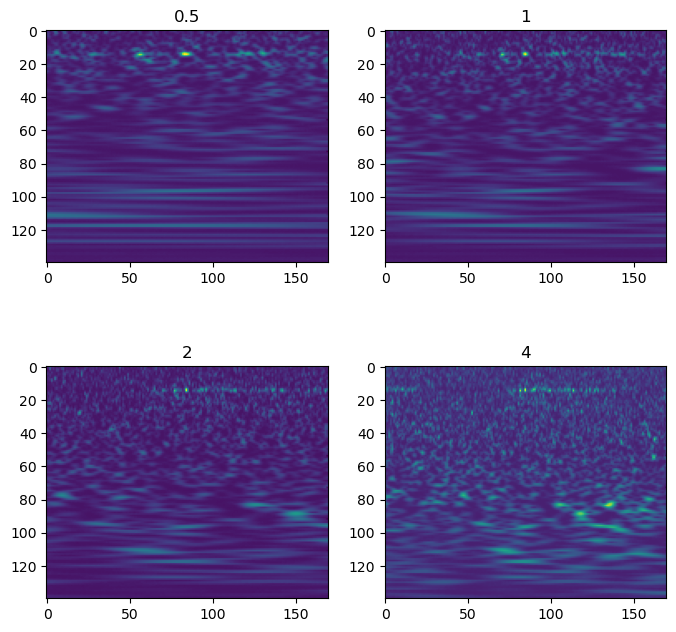

In [11]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

for ch_idx, (ax, ch_name) in enumerate(zip(axs.flatten(), [0.5, 1, 2, 4])):
    ax.imshow(sample[ch_idx])
    ax.set_title(f'{ch_name}')

Split in train, test, valid!

In [12]:
def get_data_random_by_type(type, meta, data):
    idx = np.random.choice(range(np.sum(meta['sample_type']==type)))
    id, label, sample_type = meta[meta['sample_type']==type].iloc[idx]
    stack = []
    for _, ch in data[label][sample_type][id].items():
        stack.append(ch)
    stack = np.concatenate(stack)
    return stack, label

In [13]:
sample, label = get_data_random_by_type('train', meta, data)
label

'Light_Modulation'

In [14]:
sample, label = get_data_random_by_type('test', meta, data)
label

'Light_Modulation'

In [15]:
sample, label = get_data_random_by_type('validation', meta, data)
label

'Tomte'

In [107]:
def get_data_random_by_label_and_type(label, type, meta, data):
    selection_mask = (meta['sample_type']==type) & (meta['label']==label)
    idx = np.random.choice(range(np.sum(selection_mask)))
    id, label, sample_type = meta[selection_mask].iloc[idx]
    stack = []
    for _, ch in data[label][sample_type][id].items():
        stack.append(ch)
    stack = np.concatenate(stack)
    return stack, label

In [17]:
sample, label = get_data_random_by_label_and_type('1080Lines', 'train', meta, data)
label

'1080Lines'

In [18]:
# Helper for plotting images
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_samples(samples, labels, ch=0, ncols=4):
    n = len(samples)
    nrows = -(-n // ncols)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 5), layout='constrained')

    for s, label, ax in zip(samples, labels, axs.ravel()):
        ax.imshow(s[ch])
        ax.set_title(label)
        ax.axis('off')

LABEL_NAMES = meta['label'].unique()

def show_confusion(true_labels, predicted_labels, normalize=None):
  fig, axs = plt.subplots(figsize=(9, 9))
  ConfusionMatrixDisplay(
      confusion_matrix(
        y_true=true_labels,
        y_pred=predicted_labels,
        labels=np.arange(len(LABEL_NAMES)),
        normalize=normalize
      ),
      display_labels=LABEL_NAMES,
  ).plot(ax=axs, xticks_rotation="vertical")

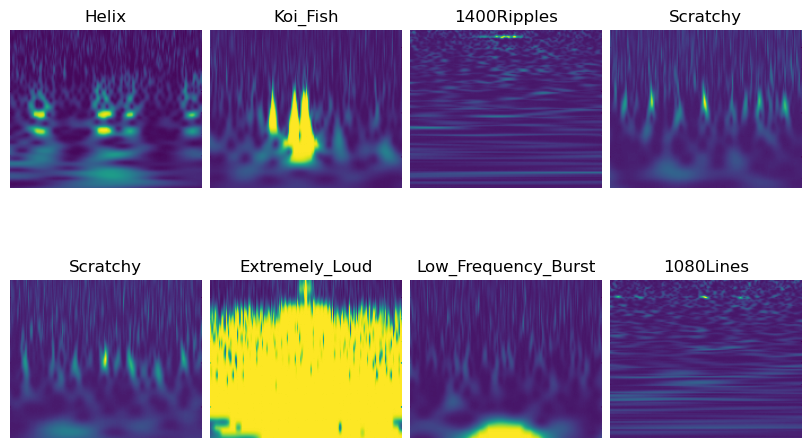

In [19]:
samples, labels = zip(*[get_data_random_by_type('train', meta, data) for i in range(8)])
show_samples(samples, labels)

In [20]:
LABEL_IDX_DICT = dict(zip(meta['label'].unique(), np.arange(len(meta['label'].unique()))))

In [21]:
label_indices = [LABEL_IDX_DICT[label] for label in labels]
label_indices

[6, 7, 1, 17, 17, 5, 9, 0]

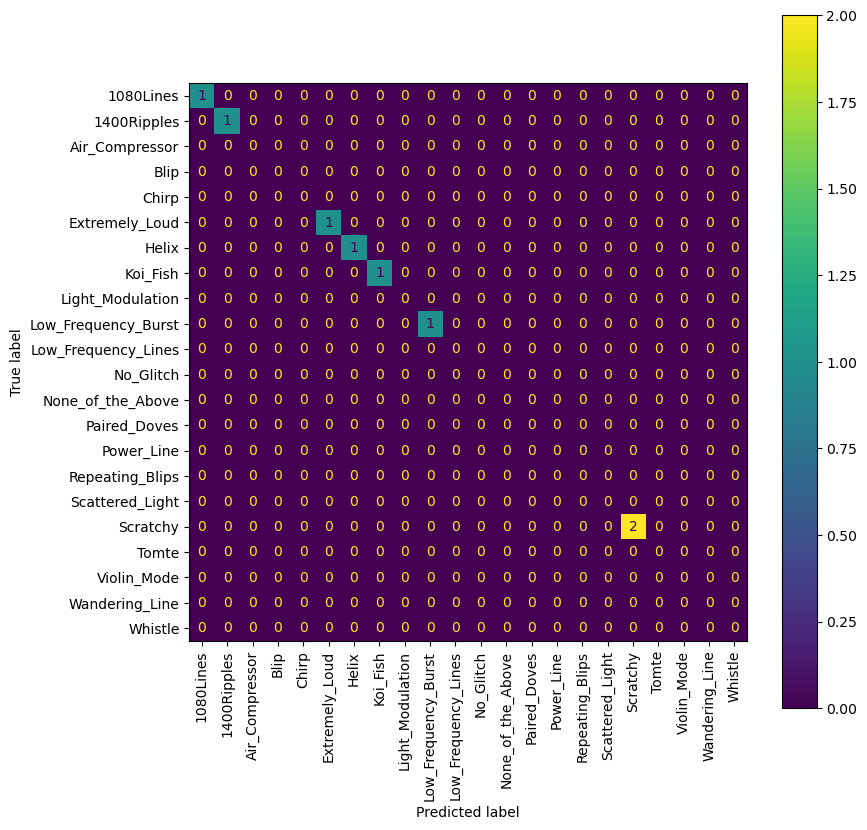

In [22]:
show_confusion(label_indices, label_indices)

# Primary Task
## 1. Train a neural network to classify the Glitches
## 2. Invest some time into optimizing your network’s performance

# Questions
1. How do you measure your network’s performance?
    - What is your reason for this choice?
    - What other good choices are there?
2. What classes stand out and why?
5. Find the Glitch images that your network performs best(worst) with. Explain why this is the case.

# Solution

I'm using pyTorch for this, so the first thing is to write a custom dataset class to handle the h5 file and meta file

In [23]:
from torch.utils.data import Dataset

class GravitySpyDataset(Dataset):
    def __init__(self, meta_file, data_file, sample_type='train', transform=None, target_transform=None):
        meta = pd.read_csv(meta_file)
        self.sample_type = sample_type
        self.meta = meta[meta['sample_type'] == sample_type]
        self.data = h5py.File(data_file, 'r')
        self.transform = transform
        self.target_transform = target_transform
        self.label = dict(zip(meta['label'].unique(), np.arange(len(meta['label'].unique()))))

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        id, label_name, _ = self.meta.iloc[idx]
        sample = []
        for _, ch in data[label_name][self.sample_type][id].items():
            sample.append(ch)
        sample = np.concatenate(sample)

        label = self.label[label_name]
        
        if self.transform:
            sample = self.transform(sample)
        if self.target_transform:
            label = self.target_transform(label)
        return sample, label

In [24]:
training_data = GravitySpyDataset('./trainingset_v1d0_metadata.csv', './trainingsetv1d0.h5', sample_type='train')

In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 4, 140, 170])
Labels batch shape: torch.Size([64])


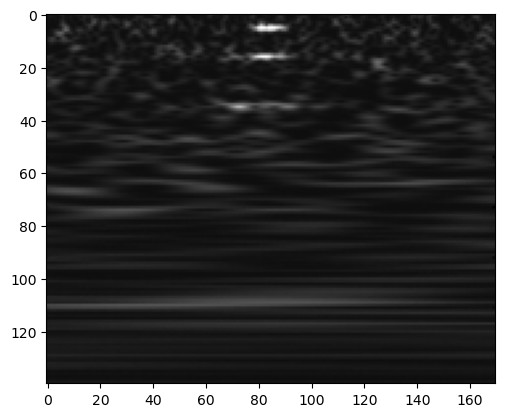

Label: 19


In [26]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

Now: Transform input to tensor and transform label to one-hot-encoding

In [27]:
from torchvision.transforms import Lambda
import torch

one_hot = Lambda(lambda y: torch.zeros(22, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))

training_data = GravitySpyDataset('./trainingset_v1d0_metadata.csv', './trainingsetv1d0.h5', sample_type='train', transform=torch.from_numpy, target_transform=one_hot)
test_data = GravitySpyDataset('./trainingset_v1d0_metadata.csv', './trainingsetv1d0.h5', sample_type='test', transform=torch.from_numpy, target_transform=one_hot)
validation_data = GravitySpyDataset('./trainingset_v1d0_metadata.csv', './trainingsetv1d0.h5', sample_type='validation', transform=torch.from_numpy, target_transform=one_hot)

In [28]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [29]:
train_features, train_labels = next(iter(train_dataloader))
train_labels[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

Build the neural network from paper, simple CNN

In [30]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [31]:
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_stack = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5),
        )
        self.flatten = nn.Flatten()
        self.lin = nn.Linear(in_features=79872, out_features=22)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.cnn_stack(x)
        x = self.flatten(x)
        x = self.lin(x)
        x = self.softmax(x)
        return x

In [32]:
model = CNN().to(device)
print(model)

CNN(
  (cnn_stack): Sequential(
    (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Linear(in_features=79872, out_features=22, bias=True)
  (softmax): Softmax(dim=1)
)


In [33]:
X = train_features.to(device=device)
logits = model(X)
X.shape

torch.Size([64, 4, 140, 170])

In [34]:
logits

tensor([[0.0477, 0.0441, 0.0425,  ..., 0.0464, 0.0493, 0.0414],
        [0.0527, 0.0454, 0.0404,  ..., 0.0410, 0.0506, 0.0421],
        [0.0457, 0.0478, 0.0467,  ..., 0.0419, 0.0486, 0.0425],
        ...,
        [0.0432, 0.0447, 0.0428,  ..., 0.0428, 0.0419, 0.0424],
        [0.0526, 0.0459, 0.0372,  ..., 0.0393, 0.0462, 0.0458],
        [0.0468, 0.0478, 0.0391,  ..., 0.0467, 0.0542, 0.0442]],
       device='mps:0', grad_fn=<SoftmaxBackward0>)

In [35]:
# Hyper parameters
learning_rate = 1e-4
batch_size = 64
epochs = 10

In [37]:
# Optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device=device))
        loss = loss_fn(pred, y.to(device=device))

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device=device))
            test_loss += loss_fn(pred, y.to(device=device)).item()
            correct += (pred.argmax(1) == y.to(device=device).argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.58E-04


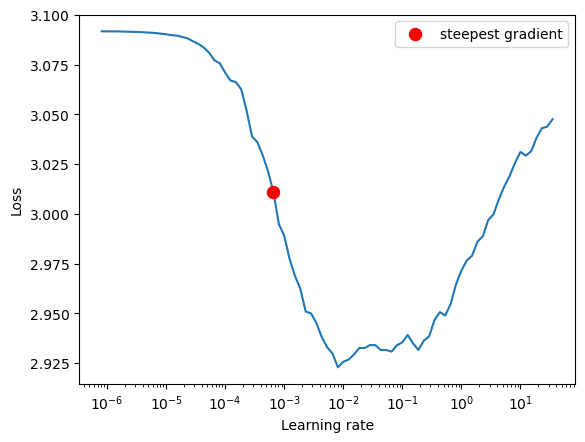

In [62]:
from torch_lr_finder import LRFinder
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_dataloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [82]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=6.58e-4, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()
epochs = 40
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.090822  [   64/ 6008]
Test Error: 
 Accuracy: 74.2%, Avg loss: 2.432664 

Epoch 2
-------------------------------
loss: 2.538352  [   64/ 6008]
Test Error: 
 Accuracy: 81.2%, Avg loss: 2.365587 

Epoch 3
-------------------------------
loss: 2.403846  [   64/ 6008]
Test Error: 
 Accuracy: 83.2%, Avg loss: 2.347581 

Epoch 4
-------------------------------
loss: 2.350471  [   64/ 6008]
Test Error: 
 Accuracy: 82.6%, Avg loss: 2.352276 

Epoch 5
-------------------------------
loss: 2.343364  [   64/ 6008]
Test Error: 
 Accuracy: 83.5%, Avg loss: 2.334318 

Epoch 6
-------------------------------
loss: 2.380728  [   64/ 6008]
Test Error: 
 Accuracy: 85.2%, Avg loss: 2.318837 

Epoch 7
-------------------------------
loss: 2.321673  [   64/ 6008]
Test Error: 
 Accuracy: 88.5%, Avg loss: 2.298507 

Epoch 8
-------------------------------
loss: 2.279043  [   64/ 6008]
Test Error: 
 Accuracy: 88.3%, Avg loss: 2.296250 

Epoch 9
----------------

In [83]:
validation_images, validation_labels = zip(*[d for d in validation_data])

In [84]:
validation_labels = torch.stack(validation_labels).argmax(1)
validation_labels

tensor([ 0,  0,  0,  ..., 21, 21, 21])

In [85]:
validation_images = torch.stack(validation_images)

In [86]:
model.eval()

CNN(
  (cnn_stack): Sequential(
    (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Linear(in_features=79872, out_features=22, bias=True)
  (softmax): Softmax(dim=1)
)

In [87]:
pred = model(validation_images.to(device=device)).argmax(1)

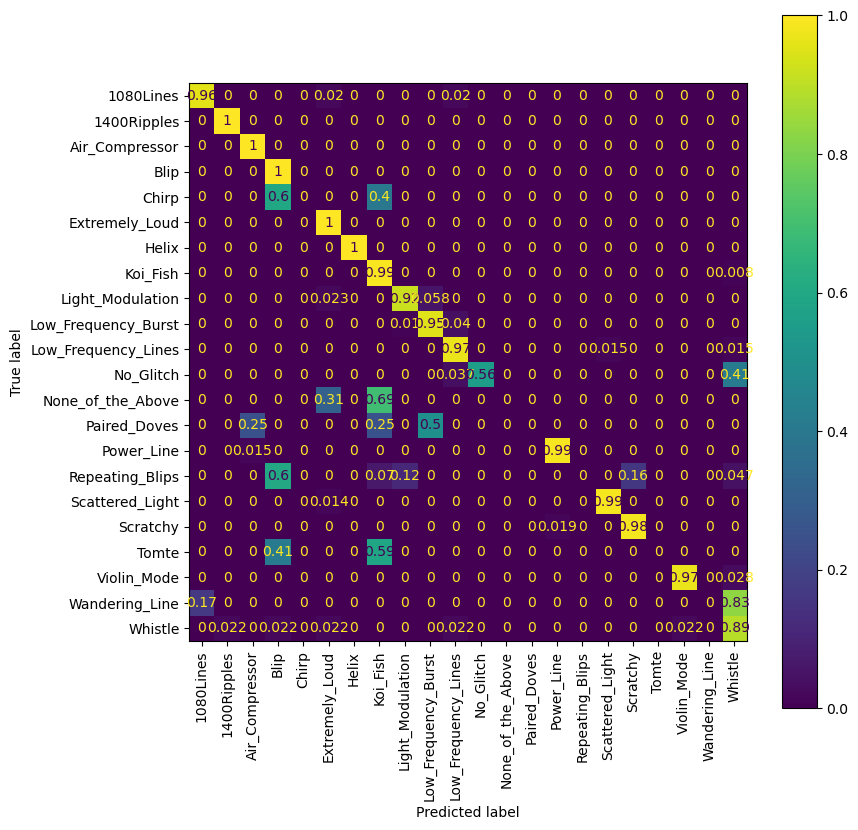

In [88]:
show_confusion(validation_labels.cpu(), pred.cpu(), normalize='true')

Problems: 
- Chirp &lrarr; Blip and Koi fish
- None of the above: mixed into a few
- Paired doves &lrarr; mostly Low freq burst
- Repeating Blips &lrarr; Blip
- Tomte &lrarr; Koi fish & Blip
- Wandering Line  &lrarr; Whistle

### Chirp

In [111]:
img_chirp, label = get_data_random_by_label_and_type('Chirp', 'validation', meta, data)

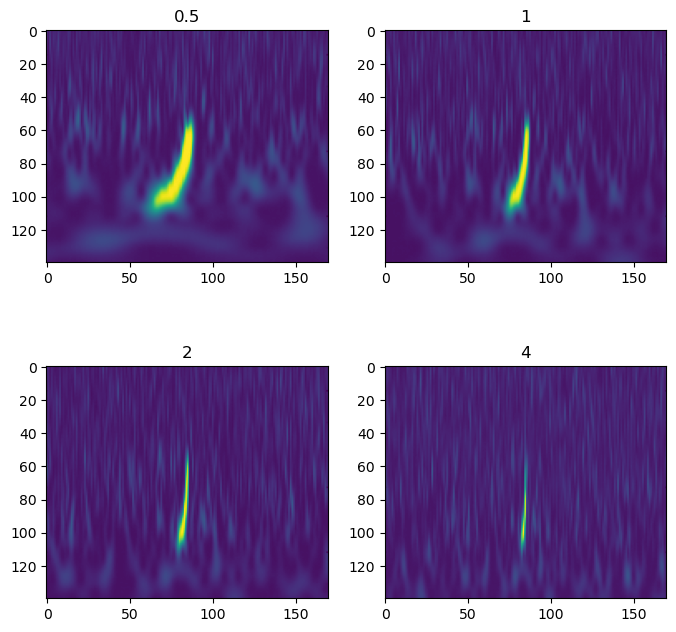

In [112]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

for ch_idx, (ax, ch_name) in enumerate(zip(axs.flatten(), [0.5, 1, 2, 4])):
    ax.imshow(img_chirp[ch_idx])
    ax.set_title(f'{ch_name}')

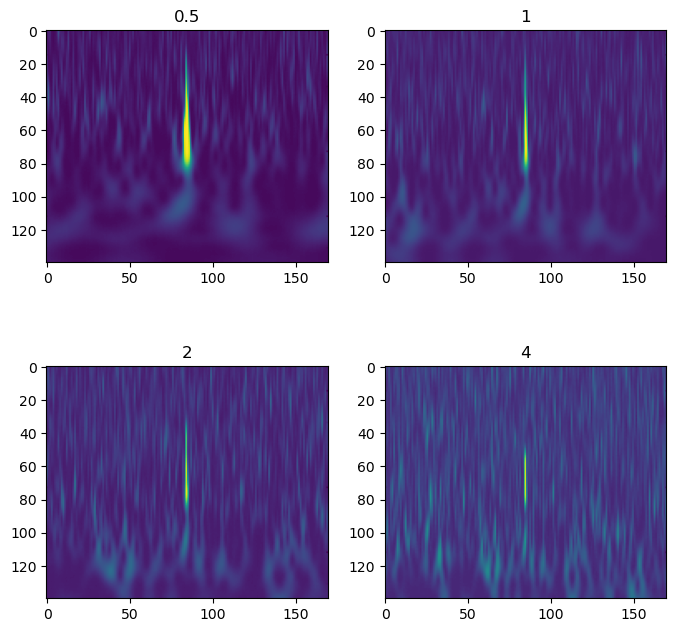

In [113]:
img_blip, label = get_data_random_by_label_and_type('Blip', 'validation', meta, data)
fig, axs = plt.subplots(2,2, figsize=(8,8))

for ch_idx, (ax, ch_name) in enumerate(zip(axs.flatten(), [0.5, 1, 2, 4])):
    ax.imshow(img_blip[ch_idx])
    ax.set_title(f'{ch_name}')

Can only be distinguish in the 0.5s frame!

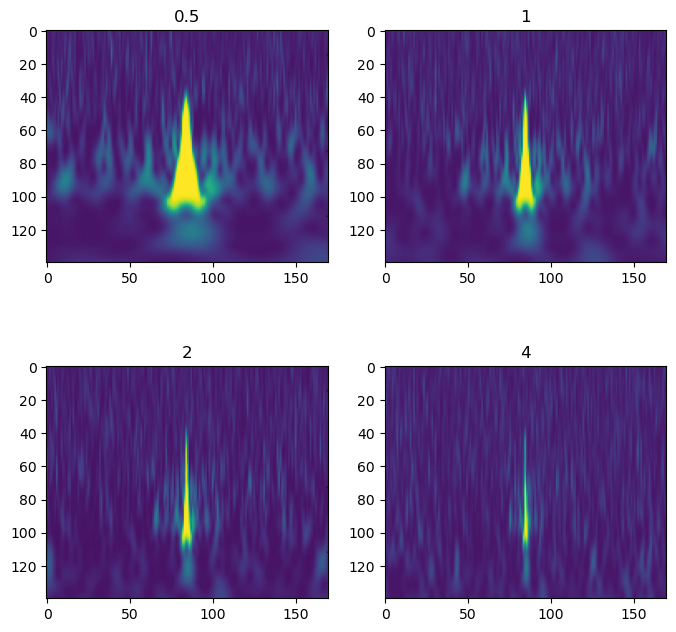

In [115]:
img_koi, label = get_data_random_by_label_and_type('Blip', 'validation', meta, data)
fig, axs = plt.subplots(2,2, figsize=(8,8))

for ch_idx, (ax, ch_name) in enumerate(zip(axs.flatten(), [0.5, 1, 2, 4])):
    ax.imshow(img_koi[ch_idx])
    ax.set_title(f'{ch_name}')

Same for the Koi fish!

### Paired doves

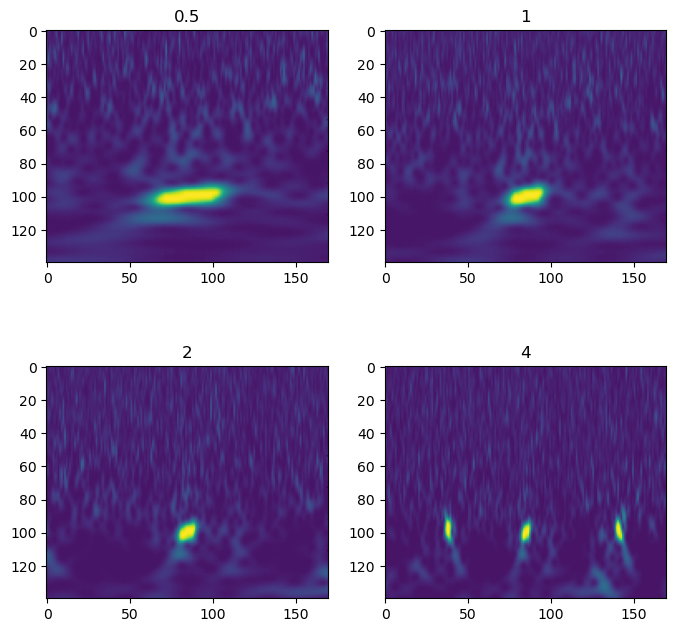

In [117]:
img_doves, label = get_data_random_by_label_and_type('Paired_Doves', 'validation', meta, data)
fig, axs = plt.subplots(2,2, figsize=(8,8))

for ch_idx, (ax, ch_name) in enumerate(zip(axs.flatten(), [0.5, 1, 2, 4])):
    ax.imshow(img_doves[ch_idx])
    ax.set_title(f'{ch_name}')

Doves only visible at largest time frame

It seems to be a problem that all time frames are handled as channels and the network doesn't know which time frame is important for which class!

And so on ...